# Assignment Info
Lab Assignment 2 - Genetic Algorithm - Robot Resource Optimization <br>
CSE366, Sec:4

Name: Md. Iftekhar Hossain Khan <br>
ID: 2020-3-60-073 <br>
Course Instructor: Dr. Mohammad Rifat Ahmmad Rashid (Assistant Professor, CSE)<br>
East West University

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Visualization of Robot Task Optimization

In [ ]:
# Improved visualization function
def visualize_assignments_improved(solution, task_durations, task_priorities, robot_efficiencies):
    # Create a grid for visualization based on the solution provided
    grid = np.zeros((len(robot_efficiencies), len(task_durations)), dtype=int)
    for task_idx, robot_idx in enumerate(solution):
        grid[robot_idx, task_idx] = task_durations[task_idx]


    fig, ax = plt.subplots(figsize=(12, 6))
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", "orange"])  # Custom colormap

    # Display the grid with task durations
    cax = ax.matshow(grid, cmap=cmap)
    fig.colorbar(cax, label='Task Duration (hours)')

    # Annotate each cell with task priority and duration
    for (i, j), z in np.ndenumerate(grid):
      tp = task_priorities[j] # for printing task priorities column wise
      td = task_durations[j]  # for printing task duration column wise
      ax.text(j, i, f'P{tp}\n{td}h', ha='center', va='center')


    # Set the ticks and labels for tasks and robots
    ax.set_xticks(np.arange(len(task_durations)))
    ax.set_yticks(np.arange(len(robot_efficiencies)))
    ax.set_xticklabels([f'Task {i+1}' for i in range(len(task_durations))], rotation=45, ha="left")
    ax.set_yticklabels([f'Robot {i+1} (Efficiency: {eff:.2f})' for i, eff in enumerate(robot_efficiencies)])

    plt.xlabel('Tasks')
    plt.ylabel('Robots')
    plt.title('Task Assignments with Task Duration and Priority')

    # Create a legend for task priorities
    priority_patches = [mpatches.Patch(color='white', label=f'Priority {i}') for i in range(1, 6)]
    plt.legend(handles=priority_patches, bbox_to_anchor=(1.20, 1), loc='upper left', title="Task Priorities")


    plt.tight_layout()
    plt.show()
    return grid

# Random Seed

In [ ]:
np.random.seed(46)

# Generate Mock Data Function

In [ ]:
def generate_mock_data(num_tasks = 10, num_robots=5):
  task_durations = np.random.randint(1, 11, size = num_tasks)
  task_priorities = np.random.randint(1, 6, size = num_tasks)
  robot_efficiencies = np.random.uniform(0.5, 1.5, size = num_robots)
  return task_durations, task_priorities, robot_efficiencies

# Genetic Algorithm Class (OptimizeRobotResource_GA)

In [ ]:
class OptimizeRobotResource_GA:
    def __init__(self, task_durations, task_priorities, robot_efficiencies, population_size=50, n_generations=100, tournament_size=5, mutation_rate=0.1):
      self.task_durations = task_durations
      self.task_priorities = task_priorities
      self.robot_efficiencies = robot_efficiencies
      self.population_size = population_size
      self.n_generations = n_generations
      self.tournament_size = tournament_size
      self.mutation_rate = mutation_rate


    def generate_population(self):
      population = [np.random.randint(0, len(self.robot_efficiencies), size=len(self.task_durations)) for _ in range(self.population_size)]
      return population


    def calc_fitness(self, solution):
      total_times = np.zeros(len(self.robot_efficiencies)) # creates an multidimentional arrays of zeros based on the robot efficiencies counts
      for task, robot in enumerate(solution):
        total_times[robot] += self.task_durations[task] * self.task_priorities[task] / self.robot_efficiencies[robot] # calculation of tr

      t_total = np.max(total_times)   # calculation of t_total
      workload = np.std(total_times)  # takes standard deviation value of the total_times
      fitness = t_total + workload    # calculates fitness function
      return fitness


    # Used Tournament Selection process here
    def selection(self, population, tournament_size):
      selected_solutions = []
      for _ in range(len(population)):
        tournament_indexes = np.random.choice(len(population), tournament_size, replace=False)  # selects some random indexes to choose from population
        tournament_solutions = [population[i] for i in tournament_indexes]                      # selects populations based on tournament indexes
        tournament_fitness = [self.calc_fitness(sol) for sol in tournament_solutions]           # calculates fitness of each of the selected solutions
        winner_index = np.argmin(tournament_fitness)                                            # gets the fitted solution index
        selected_solutions.append(tournament_solutions[winner_index])                           # appends those selected fitted solutions here
      return selected_solutions


    def crossover(self, parent1, parent2):
        crossover_point = np.random.randint(1, len(parent1))                                    # chooses crossover point randomly based on the parents count value
        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))         # creates first child from the parents based on the crossover point
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))         # creates second child from the parents
        return child1, child2


    def mutate(self, solution, mutation_rate):
        mutated_solution = solution.copy()
        for i in range(len(mutated_solution)):
            if np.random.rand() < mutation_rate:                                                # if the random value is less than the mutation rate begin swap
                swap_idx = np.random.randint(len(mutated_solution))                             # chooses a random number for swapping
                mutated_solution[i], mutated_solution[swap_idx] = mutated_solution[swap_idx], mutated_solution[i]  # swaps values to do mutation process
        return mutated_solution

    def run_simulation(self):
        best_solution = None
        best_fitness = float('inf')
        best_generation = None
        population = self.generate_population()
        for generation in range(self.n_generations):
          parents = self.selection(population, self.tournament_size)        # selection of the parents
          next_generation = []                                              # empty list for the next generation
          for i in range(0, len(parents), 2):
              parent1, parent2 = parents[i], parents[i+1]
              child1, child2 = self.crossover(parent1, parent2)
              child1 = self.mutate(child1, self.mutation_rate)              # gets mutated child1 and child2 from the selected parents
              child2 = self.mutate(child2, self.mutation_rate)
              next_generation.extend([child1, child2])                      # stores the mutated child the list
          population = next_generation

          # Evaluate fitness of the best solution in the current generation
          current_best_solution = min(population, key=self.calc_fitness)
          current_best_fitness = self.calc_fitness(current_best_solution)
          if current_best_fitness < best_fitness:
              best_solution = current_best_solution
              best_fitness = current_best_fitness
              best_generation = generation

        return best_solution, best_generation

# Running simulation using class (OptimizeRobotResource_GA)

Task Durations: [10  1  5  2  3  6 10  6  4  8] Total: 55h
Task Priorities: [2 3 3 2 5 4 2 3 5 3]
Robot Efficiencies: [0.85093228 1.12317089 0.63567646 0.53138628 0.69709284]
Best Solution: [1 3 4 1 4 2 3 0 0 1]
At Generation: 7


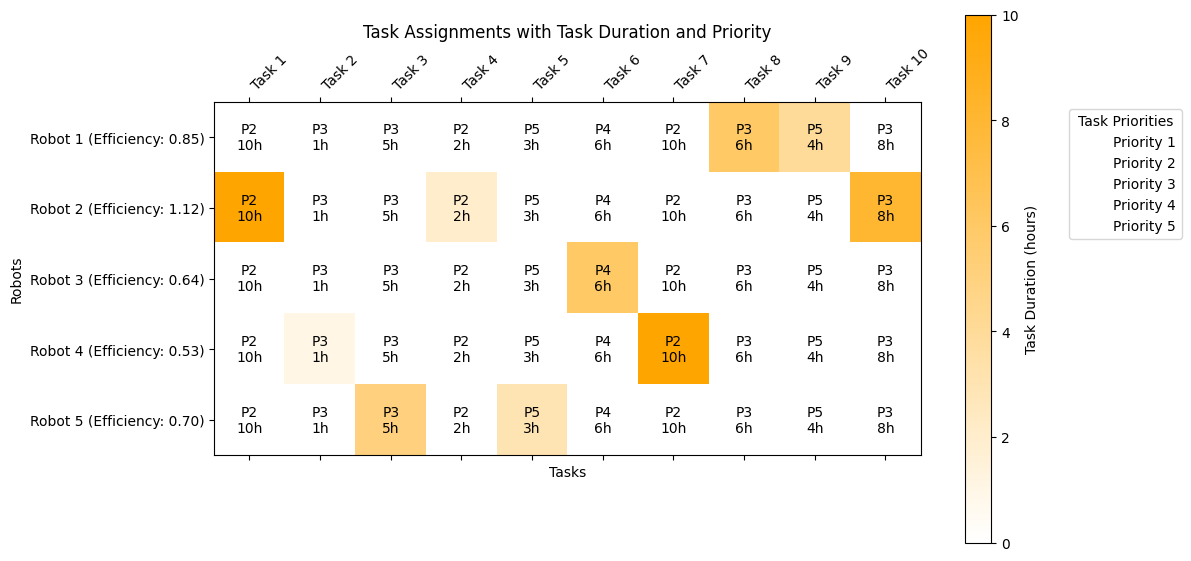

In [ ]:
    # defining parameters
    num_tasks = 10
    num_robots = 5

    population_size = 50
    n_generations = 100
    tournament_size = 5
    mutation_rate = 0.1

    # generating mock datas
    task_durations, task_priorities, robot_efficiencies = generate_mock_data(num_tasks, num_robots)

    print(f'Task Durations: {task_durations} Total: {np.sum(task_durations)}h')
    print(f'Task Priorities: {task_priorities}')
    print(f'Robot Efficiencies: {robot_efficiencies}')

    # Run GA to find the best solution
    runGA = OptimizeRobotResource_GA(task_durations, task_priorities, robot_efficiencies, population_size, n_generations, tournament_size, mutation_rate)
    best_solution, best_generation = runGA.run_simulation()
    print(f'Best Solution: {best_solution}')
    print(f'At Generation: {best_generation}')

    # Visualize the initial random assignment
    grid = visualize_assignments_improved(best_solution, task_durations, task_priorities, robot_efficiencies)

# Debugging and exploring new stuff

In [ ]:
runGA.calc_fitness(best_solution)

46.10064435485727

In [ ]:
grid

array([[ 0,  0,  9,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  7,  0,  6,  0,  8,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8, 10,  0],
       [ 0,  0,  0,  0,  2,  0,  0,  0,  0,  9],
       [10,  0,  0,  0,  0,  0,  9,  0,  0,  0]])

In [ ]:
population_size = 50
population = [np.random.randint(0, len(robot_efficiencies),
                                size=len(task_durations)) for _ in range(population_size)]

task_durations, task_priorities, robot_efficiencies = generate_mock_data(10, 5)

def calc_fitness(solution, task_durations, task_priorities, robot_efficiencies):
      total_times = np.zeros(len(robot_efficiencies))
      for task, robot in enumerate(solution):
        total_times[robot] += task_durations[task] * task_priorities[task] / robot_efficiencies[robot]

      t_total = np.max(total_times) #calculation of t_total
      workload = np.std(total_times) # taking standard deviation value of the total_times
      fitness = t_total + workload #calculating fitness function
      return fitness

In [ ]:
tournament_indices = np.random.choice(len(population), 10, replace=False)
tournament_indices

array([35, 20, 31, 18, 13, 44, 26, 30, 21,  4])

In [ ]:
tournament_solutions = [population[i] for i in tournament_indices]
tournament_solutions

[array([4, 0, 4, 2, 4, 1, 0, 2, 2, 0]),
 array([2, 2, 0, 2, 4, 2, 4, 4, 4, 1]),
 array([3, 2, 4, 0, 4, 4, 0, 3, 0, 2]),
 array([4, 4, 0, 1, 0, 1, 1, 0, 2, 4]),
 array([4, 3, 0, 3, 0, 3, 4, 2, 1, 1]),
 array([1, 4, 3, 1, 2, 2, 0, 1, 3, 2]),
 array([0, 3, 3, 0, 4, 3, 1, 3, 3, 3]),
 array([1, 4, 2, 1, 2, 4, 2, 2, 0, 1]),
 array([3, 4, 2, 3, 3, 3, 1, 1, 1, 0]),
 array([0, 1, 2, 3, 4, 1, 3, 3, 1, 3])]

In [ ]:
tournament_fitness = [calc_fitness(sol, task_durations, task_priorities, robot_efficiencies) for sol in tournament_solutions]
tournament_fitness

[59.24198131561283,
 79.56887136327202,
 59.32411891174733,
 105.79767341691326,
 78.60817373260008,
 98.89889330015326,
 82.12612124987618,
 70.87408384520793,
 86.79298051362427,
 75.11097036398868]

In [ ]:
winner_index = np.argmin(tournament_fitness)
winner_index

0

In [ ]:
selected_solutions = []
for _ in range(len(population)):
  tournament_indices = np.random.choice(len(population), 10, replace=False)
  tournament_solutions = [population[i] for i in tournament_indices]
  tournament_fitness = [calc_fitness(sol, task_durations, task_priorities, robot_efficiencies) for sol in tournament_solutions]
  winner_index = np.argmin(tournament_fitness)
  selected_solutions.append(tournament_solutions[winner_index])
selected_solutions

[array([2, 1, 0, 2, 3, 1, 4, 1, 1, 2]),
 array([0, 3, 3, 0, 4, 3, 1, 3, 3, 3]),
 array([0, 1, 2, 1, 3, 0, 0, 3, 0, 0]),
 array([1, 0, 3, 4, 2, 0, 1, 2, 3, 3]),
 array([0, 1, 2, 4, 3, 2, 1, 1, 0, 0]),
 array([1, 1, 4, 4, 0, 3, 1, 1, 0, 2]),
 array([0, 1, 2, 4, 3, 2, 1, 1, 0, 0]),
 array([3, 2, 4, 0, 1, 0, 1, 4, 0, 1]),
 array([0, 0, 1, 1, 3, 4, 2, 1, 3, 0]),
 array([3, 2, 4, 0, 1, 0, 1, 4, 0, 1]),
 array([0, 3, 3, 0, 4, 3, 1, 3, 3, 3]),
 array([1, 1, 4, 4, 0, 3, 1, 1, 0, 2]),
 array([1, 0, 3, 4, 2, 0, 1, 2, 3, 3]),
 array([0, 1, 2, 4, 3, 2, 1, 1, 0, 0]),
 array([4, 3, 3, 4, 1, 0, 0, 4, 3, 1]),
 array([0, 1, 2, 1, 3, 0, 0, 3, 0, 0]),
 array([0, 1, 2, 4, 3, 2, 1, 1, 0, 0]),
 array([0, 1, 2, 4, 3, 2, 1, 1, 0, 0]),
 array([0, 0, 1, 1, 3, 4, 2, 1, 3, 0]),
 array([1, 2, 2, 0, 0, 2, 3, 1, 3, 3]),
 array([1, 0, 3, 4, 2, 0, 1, 2, 3, 3]),
 array([0, 1, 2, 4, 3, 2, 1, 1, 0, 0]),
 array([2, 1, 0, 2, 3, 1, 4, 1, 1, 2]),
 array([0, 1, 2, 3, 4, 1, 3, 3, 1, 3]),
 array([4, 2, 2, 1, 1, 0, 1, 3, 2, 4]),


In [ ]:
np.sum(task_durations)

39

In [ ]:
g = np.zeros((len(robot_efficiencies), len(task_durations)), dtype=int)
g

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
s = np.random.randint(1, 5, size=(5, 10))
s

array([[1, 3, 2, 1, 4, 2, 4, 4, 1, 2],
       [1, 4, 4, 3, 2, 1, 1, 2, 3, 1],
       [2, 4, 1, 1, 3, 4, 4, 3, 3, 4],
       [4, 2, 1, 2, 3, 3, 4, 2, 3, 2],
       [2, 4, 1, 1, 1, 1, 1, 2, 4, 2]])

In [ ]:
grid

array([[ 0,  0,  9,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  7,  0,  6,  0,  8,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8, 10,  0],
       [ 0,  0,  0,  0,  2,  0,  0,  0,  0,  9],
       [10,  0,  0,  0,  0,  0,  9,  0,  0,  0]])

In [ ]:
print(f'Task Durations: {task_durations}')
print(f'Task Priorities: {task_priorities}')
print(f'Robot Efficiencies: {robot_efficiencies}')
print(f'Best Solution: {best_solution}')

Task Durations: [10  7  9  6  2  8  9  8 10  9]
Task Priorities: [3 2 4 5 1 1 1 1 1 2]
Robot Efficiencies: [0.95288619 1.41610767 0.53493914 0.57131496 1.16590313]
Best Solution: [4 1 0 1 3 1 4 2 2 3]


In [ ]:
for (i, j), z in np.ndenumerate(grid):
      t = task_priorities[j]
      print(j, i, f'P{t} {z}h')

0 0 P3 0h
1 0 P2 0h
2 0 P4 9h
3 0 P5 0h
4 0 P1 0h
5 0 P1 0h
6 0 P1 0h
7 0 P1 0h
8 0 P1 0h
9 0 P2 0h
0 1 P3 0h
1 1 P2 7h
2 1 P4 0h
3 1 P5 6h
4 1 P1 0h
5 1 P1 8h
6 1 P1 0h
7 1 P1 0h
8 1 P1 0h
9 1 P2 0h
0 2 P3 0h
1 2 P2 0h
2 2 P4 0h
3 2 P5 0h
4 2 P1 0h
5 2 P1 0h
6 2 P1 0h
7 2 P1 8h
8 2 P1 10h
9 2 P2 0h
0 3 P3 0h
1 3 P2 0h
2 3 P4 0h
3 3 P5 0h
4 3 P1 2h
5 3 P1 0h
6 3 P1 0h
7 3 P1 0h
8 3 P1 0h
9 3 P2 9h
0 4 P3 10h
1 4 P2 0h
2 4 P4 0h
3 4 P5 0h
4 4 P1 0h
5 4 P1 0h
6 4 P1 9h
7 4 P1 0h
8 4 P1 0h
9 4 P2 0h


In [ ]:
for task, robot in enumerate(best_solution):
  print(f'Task: {task+1} Robot: {robot+1}')

Task: 1 Robot: 5
Task: 2 Robot: 2
Task: 3 Robot: 1
Task: 4 Robot: 2
Task: 5 Robot: 4
Task: 6 Robot: 2
Task: 7 Robot: 5
Task: 8 Robot: 3
Task: 9 Robot: 3
Task: 10 Robot: 4
